## BUSINESS CASE :

### Business Problem
The case business case is on the inventory management. Keeping Inventory of spare in various service centre to the market demand is always a challenge as most service centres spends significant amount in spare parts inventory costs. In spite of this, availability of spare parts is been one of the problem areas. 

PROJECT GOAL: 1. Create Predictive model for inventory forecasting so that service centre achieve JIT standards.

In [160]:
import warnings
warnings.filterwarnings('ignore')

## INSTALL REQUIRED LIBRARIES

In [163]:
!pip install pandas sqlalchemy pymysql matplotlib seaborn scikit-learn statsmodels ydata-profiling pmdarima

In [164]:
!pip install ipywidgets

In [165]:
!pip install pmdarima ydata-profiling

In [166]:
%matplotlib inline

## IMPORT LIBRARIES

In [168]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import pmdarima as pm
from sklearn.metrics import mean_absolute_error

## DATABASE CONNECTION AND BASIC CHECKS

In [170]:
# Connection parameters
user = 'dm_usdata_sql'
password = '37z<49REb&mKnl4AV!vJ'
host = '18.136.157.135'
db = 'project_service_data'
table = 'service_data'

engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{db}')
query = f"SELECT * FROM {table}"
df = pd.read_sql(query, engine)

print(f"Loaded {len(df)} records.")
df.head()

Loaded 28482 records.


invoice_date job_card_date business_partner_name  vehicle_no  \
0     30-05-17      30-05-17        shivXXXXXXXXXX  KA03MFXXXX   
1     02-06-17      31-05-17        KIRAXXXXXXXXXX  KA53ESXXXX   
2     02-06-17      31-05-17        KIRAXXXXXXXXXX  KA53ESXXXX   
3     02-06-17      31-05-17        KIRAXXXXXXXXXX  KA53ESXXXX   
4     02-06-17      31-05-17        KIRAXXXXXXXXXX  KA53ESXXXX   

              vehicle_model current_km_reading invoice_line_text  
0  BAJAJ AVENGER STREET 220              50000        ENGINE OIL  
1       BAJAJ PULSAR NS 200                758        ENGINE OIL  
2       BAJAJ PULSAR NS 200                758            POLISH  
3       BAJAJ PULSAR NS 200                758       CONSUMABLES  
4       BAJAJ PULSAR NS 200                758       COOLANT OIL

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28482 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   invoice_date           28482 non-null  object
 1   job_card_date          28482 non-null  object
 2   business_partner_name  28482 non-null  object
 3   vehicle_no             28482 non-null  object
 4   vehicle_model          28482 non-null  object
 5   current_km_reading     28482 non-null  object
 6   invoice_line_text      28476 non-null  object
dtypes: object(7)
memory usage: 1.5+ MB


In [172]:
df.describe()

invoice_date job_card_date business_partner_name  vehicle_no  \
count         28482         28482                 28482       28482   
unique          555           553                  1010         846   
top        01-12-18      01-12-18        venkXXXXXXXXXX  KA53EVXXXX   
freq            179           179                   424        1313   

           vehicle_model current_km_reading invoice_line_text  
count              28482              28482             28476  
unique                28               3474               503  
top     BAJAJ PULSAR 150                  0        ENGINE OIL  
freq                8633                842              3802

In [173]:
df.isnull().sum()

invoice_date             0
job_card_date            0
business_partner_name    0
vehicle_no               0
vehicle_model            0
current_km_reading       0
invoice_line_text        6
dtype: int64

## EXPLORATORY DATA ANALYSIS (EDA)

In [175]:
# Generate EDA report
profile = ProfileReport(df, title="Spare Parts Data Profile", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.74it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [177]:
# Data info and description
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28482 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   invoice_date           28482 non-null  object
 1   job_card_date          28482 non-null  object
 2   business_partner_name  28482 non-null  object
 3   vehicle_no             28482 non-null  object
 4   vehicle_model          28482 non-null  object
 5   current_km_reading     28482 non-null  object
 6   invoice_line_text      28476 non-null  object
dtypes: object(7)
memory usage: 1.5+ MB


invoice_date job_card_date business_partner_name  vehicle_no  \
count         28482         28482                 28482       28482   
unique          555           553                  1010         846   
top        01-12-18      01-12-18        venkXXXXXXXXXX  KA53EVXXXX   
freq            179           179                   424        1313   

           vehicle_model current_km_reading invoice_line_text  
count              28482              28482             28476  
unique                28               3474               503  
top     BAJAJ PULSAR 150                  0        ENGINE OIL  
freq                8633                842              3802

In [178]:
df['business_partner_name'].value_counts()

business_partner_name
venkXXXXXXXXXX    424
manjXXXXXXXXXX    362
prasXXXXXXXXXX    328
shivXXXXXXXXXX    314
chanXXXXXXXXXX    312
                 ... 
SUMAXXXXXXXXXX      1
VIRUXXXXXXXXXX      1
ARGHXXXXXXXXXX      1
revaXXXXXXXXXX      1
a veXXXXXXXXXX      1
Name: count, Length: 1010, dtype: int64

## DATA PREPROCESSING

In [180]:
# Handle duplicates and dates
df.drop_duplicates(inplace=True)
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')
df['job_card_date'] = pd.to_datetime(df['job_card_date'], errors='coerce')
df['invoice_line_text'].fillna('Unknown', inplace=True)

# Standardize column names
df.columns = df.columns.str.lower()

# Extract spare parts (expand keywords as needed)
part_keywords = {
    'OIL FILTER': ['oil filter', 'filter oil'],
    'AIR FILTER': ['air filter', 'filter air'],
    'BRAKE PAD': ['brake pad', 'pad brake'],
    'SPARK PLUG': ['spark plug', 'plug spark']
}

def extract_part(text):
    text = text.lower()
    for part, keywords in part_keywords.items():
        if any(kw in text for kw in keywords):
            return part
    return 'Other'

df['spare_part'] = df['invoice_line_text'].apply(extract_part)

## PREPARING DATA FOR FORECASTING

In [182]:
# Group by Month and Part Name
monthly_data = df.groupby([pd.Grouper(key='invoice_date', freq='M'),'invoice_line_text']).size().reset_index(name='quantity')

In [183]:
monthly_data.shape

(3352, 3)

In [184]:
# Get most frequently used parts
top_parts = df['invoice_line_text'].value_counts().head(2).index.tolist()

# Filter one part's data
selected_part = top_parts[0]
part_df = monthly_data[monthly_data['invoice_line_text'] == selected_part]
part_df = part_df.set_index('invoice_date')[['quantity']].asfreq('M').fillna(0)

In [200]:
# Convert invoice_date to datetime first
monthly_data['invoice_date'] = pd.to_datetime(monthly_data['invoice_date'], errors="coerce")

top_parts = df['invoice_line_text'].value_counts().head(2).index.tolist()
selected_part = top_parts[0]

part_df = monthly_data[monthly_data['invoice_line_text'] == selected_part]

# Normalize column names to be safe
part_df.columns = part_df.columns.str.strip().str.lower()

# Use lowercase consistently
part_df = (
    part_df.set_index('invoice_date')[['quantity']]
           .asfreq('M')
           .fillna(0)
)

In [202]:
top_parts

['ENGINE OIL', 'CHAIN LUBRICATION']

In [204]:
part_df['quantity']

invoice_date
2017-01-31     45.0
2017-02-28     44.0
2017-03-31     33.0
2017-04-30     48.0
2017-05-31     40.0
2017-06-30    155.0
2017-07-31    153.0
2017-08-31    119.0
2017-09-30    156.0
2017-10-31    123.0
2017-11-30    142.0
2017-12-31    188.0
2018-01-31    171.0
2018-02-28    187.0
2018-03-31    229.0
2018-04-30    228.0
2018-05-31    226.0
2018-06-30    211.0
2018-07-31    197.0
2018-08-31    197.0
2018-09-30    184.0
2018-10-31    230.0
2018-11-30    222.0
2018-12-31    214.0
2019-01-31      0.0
2019-02-28      6.0
2019-03-31      6.0
2019-04-30     11.0
2019-05-31     11.0
2019-06-30      4.0
Freq: ME, Name: quantity, dtype: float64

In [206]:
monthly_data.head() # group by month & quantity

invoice_date   invoice_line_text  quantity
0   2017-01-31              3M OIL        19
1   2017-01-31          AIR FILTER        12
2   2017-01-31  AIR FILTER CHECKUP        14
3   2017-01-31        BATTERY BELT         1
4   2017-01-31            BORE KIT         3

In [208]:
part_df.index = pd.to_datetime(part_df.index)

In [210]:
print(part_df.index)   # should be DatetimeIndex
print(part_df.dtypes)  # Quantity should be numeric
print(part_df.shape)

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30'],
              dtype='datetime64[ns]', name='invoice_date', freq='ME')
quantity    float64
dtype: object
(30, 1)


## VISUALIZATIONS

In [213]:
data1 = df.copy()
data1

invoice_date job_card_date business_partner_name  vehicle_no  \
0       2017-05-30    2017-05-30        shivXXXXXXXXXX  KA03MFXXXX   
1       2017-02-06    2017-05-31        KIRAXXXXXXXXXX  KA53ESXXXX   
2       2017-02-06    2017-05-31        KIRAXXXXXXXXXX  KA53ESXXXX   
3       2017-02-06    2017-05-31        KIRAXXXXXXXXXX  KA53ESXXXX   
4       2017-02-06    2017-05-31        KIRAXXXXXXXXXX  KA53ESXXXX   
...            ...           ...                   ...         ...   
28477   2019-06-01    2019-06-01        pravXXXXXXXXXX  KA53EVXXXX   
28478   2019-06-01    2019-06-01        pravXXXXXXXXXX  KA53EVXXXX   
28479   2019-06-01    2019-06-01        pravXXXXXXXXXX  KA53EVXXXX   
28480   2019-06-01    2019-06-01        pravXXXXXXXXXX  KA53EVXXXX   
28481   2019-06-01    2019-06-01        pravXXXXXXXXXX  KA53EVXXXX   

                  vehicle_model current_km_reading invoice_line_text  \
0      BAJAJ AVENGER STREET 220              50000        ENGINE OIL   
1           BAJAJ PULSAR NS 200                758        ENGINE OIL   
2           BAJAJ PULSAR NS 200                758            POLISH   
3           BAJAJ PULSAR NS 200                758       CONSUMABLES   
4           BAJAJ PULSAR NS 200                758       COOLANT OIL   
...                         ...                ...               ...   
28477        BAJAJ DISCOVER 125              12805   SPROCKET RUBBER   
28478        BAJAJ DISCOVER 125              12805      CLUTCH CABLE   
28479        BAJAJ DISCOVER 125              12805        OIL FILTER   
28480        BAJAJ DISCOVER 125              12805          DISC OIL   
28481        BAJAJ DISCOVER 125              12805        AIR FILTER   

       spare_part  
0           Other  
1           Other  
2           Other  
3           Other  
4           Other  
...           ...  
28477       Other  
28478       Other  
28479  OIL FILTER  
28480       Other  
28481  AIR FILTER  

[28099 rows x 8 columns]

In [215]:
monthly_data.shape

(3352, 3)

In [217]:
print(part_df.head())
print(part_df.columns)

              quantity
invoice_date          
2017-01-31        45.0
2017-02-28        44.0
2017-03-31        33.0
2017-04-30        48.0
2017-05-31        40.0
Index(['quantity'], dtype='object')


In [219]:
print(f"DataFrame shape: {part_df.shape}")

DataFrame shape: (30, 1)


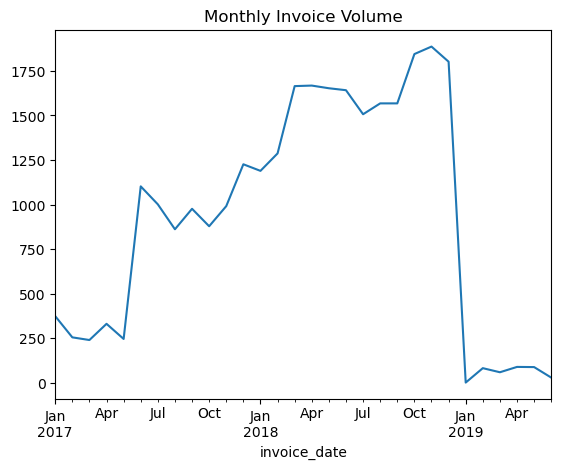

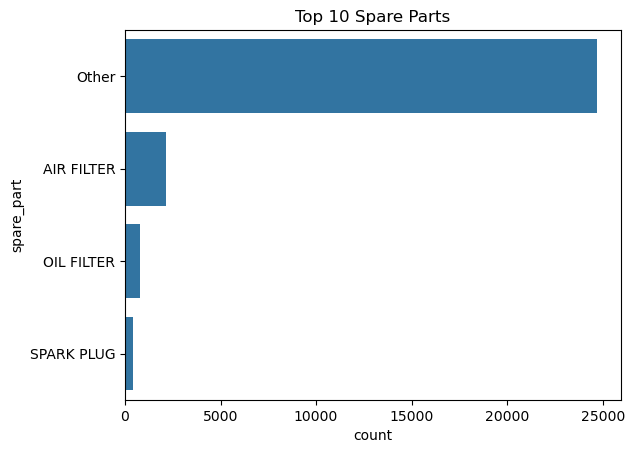

In [221]:
# Monthly invoice volume
df.set_index('invoice_date').resample('M').size().plot()
plt.title('Monthly Invoice Volume')
plt.show()

# Top spare parts
sns.countplot(y='spare_part', data=df, order=df['spare_part'].value_counts().index[:10])
plt.title('Top 10 Spare Parts')
plt.show()

## INSIGHTS : 
- We can see a sharp increase in invoice volume from mid-2017, rising consistently throughout 2018 and late 2018, with monthly volumes reaching near 1800.
- After January 2019, there was significant drop in invoice volume, staying very low for the rest of the period shown.
- The post-2019 period shows a stable but minimal monthly volume.



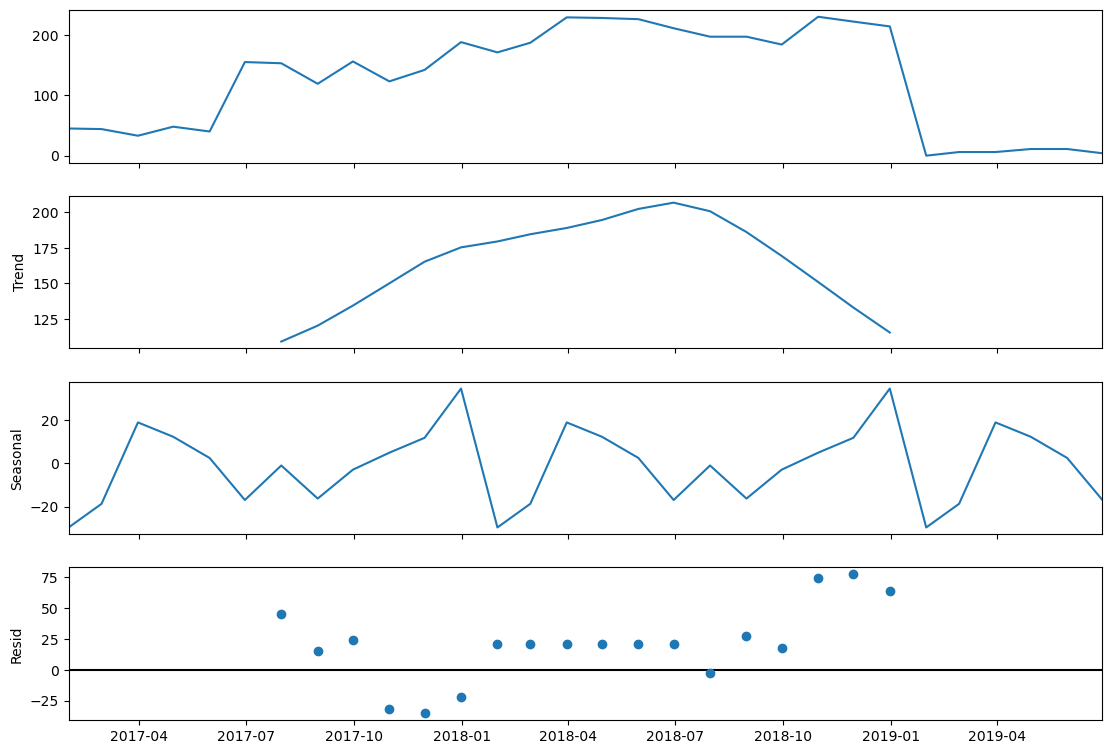

In [224]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series [To divide them as 'Trend', 'Seasonality', 'Residual']
decomposition = seasonal_decompose(part_df, model='additive')

# Plotting of decomposed components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# INSIGHTS:
- Trend: There is a clear upward trend from early 2017 through mid-2018, peaking around late 2018, followed by a decline in 2019. This indicates overall growth before a downturn.
- Seasonality: Strong seasonal spikes are visible at regular intervals (i.e, early 2017, mid-2018, and early 2019), showing repeating patterns that could be linked to cyclical or periodic factors.
- Residuals: Residuals vary across the period, with noticeable deviations (both positive and negative) especially in late 2017–early 2018 and late 2018–early 2019, suggesting unexpected shocks or irregular variations beyond trend and seasonality.

In [226]:
part_df

quantity
invoice_date          
2017-01-31        45.0
2017-02-28        44.0
2017-03-31        33.0
2017-04-30        48.0
2017-05-31        40.0
2017-06-30       155.0
2017-07-31       153.0
2017-08-31       119.0
2017-09-30       156.0
2017-10-31       123.0
2017-11-30       142.0
2017-12-31       188.0
2018-01-31       171.0
2018-02-28       187.0
2018-03-31       229.0
2018-04-30       228.0
2018-05-31       226.0
2018-06-30       211.0
2018-07-31       197.0
2018-08-31       197.0
2018-09-30       184.0
2018-10-31       230.0
2018-11-30       222.0
2018-12-31       214.0
2019-01-31         0.0
2019-02-28         6.0
2019-03-31         6.0
2019-04-30        11.0
2019-05-31        11.0
2019-06-30         4.0

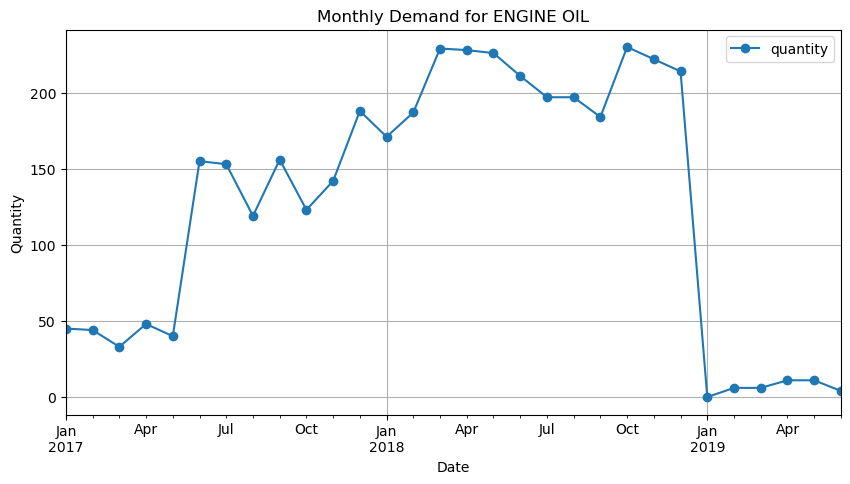

In [227]:
# Example for visualizing a single spare part's demand
import matplotlib.pyplot as plt
import seaborn as snsh
part_df['quantity'] = pd.to_numeric(part_df['quantity'], errors='coerce').fillna(0)
part_df.plot(figsize=(10, 5), marker='o')
plt.title(f"Monthly Demand for {selected_part}")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.grid(True)
plt.show()

# INSIGHTS :
- It represents demand of Engine oil surged sharply in mid-2017, stabilizing at much higher levels [ 150–225 units ] through 2018.
- There was a sudden and steep drop in demand from January 2019, with monthly quantities remaining very low afterward.
- After 2019 there is no sign of significant growth; quantities remain consistently much lower than the previous peak period.


## BUILD FORECASTING MODEL

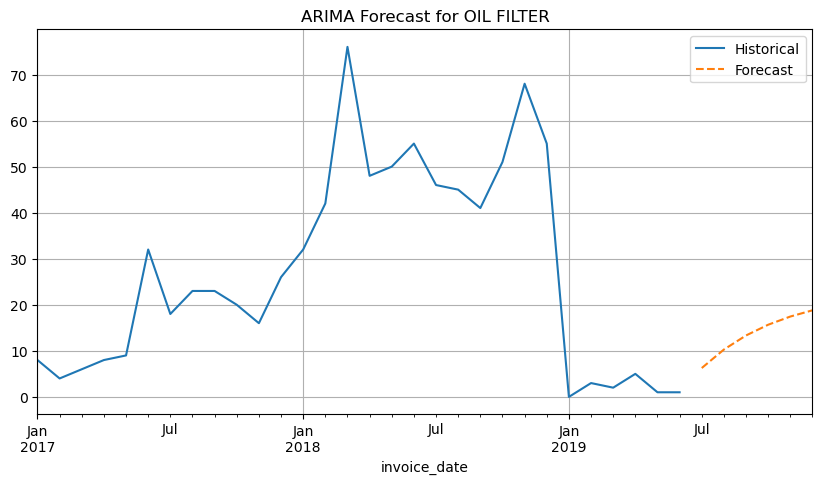

In [290]:
# importing ARIMA model

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(part_df, order=(1,0,0))
fit = model.fit()
forecast = fit.forecast(6)

# Plot
part_df.plot(label='Historical', figsize=(10, 5))
forecast.plot(label='Forecast', linestyle='--')
plt.title(f"ARIMA Forecast for {selected_part}")
plt.legend()
plt.grid(True)
plt.show()

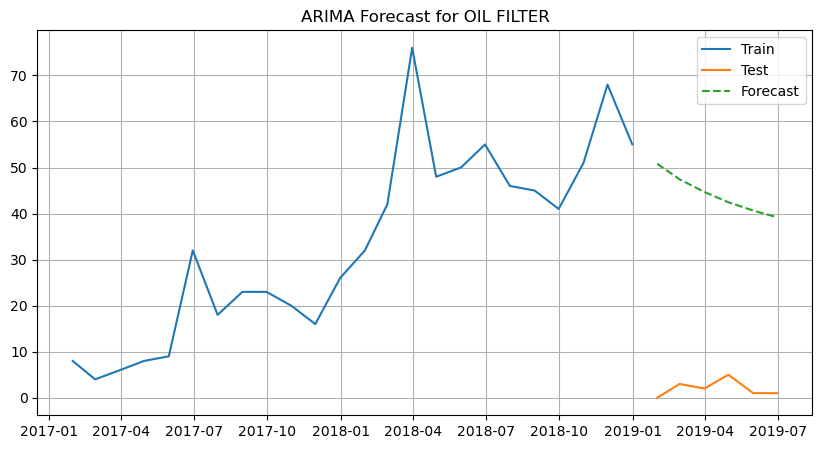

In [292]:
# Split data into train & test
train = part_df.iloc[:-6]   # all but last 6 periods
test = part_df.iloc[-6:]    # last 6 periods

# Fit ARIMA
model = ARIMA(train, order=(1,0,0))
fit = model.fit()

# Forecast same length as test
forecast = fit.forecast(len(test))

# Plot
plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title(f"ARIMA Forecast for {selected_part}")
plt.legend()
plt.grid(True)
plt.show()

In [293]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("MAE:", mae)
print("RMSE:", rmse)

# Error is large , arima model isn't accurate.

MAE: 42.20515965867801
RMSE: 42.45054361631517


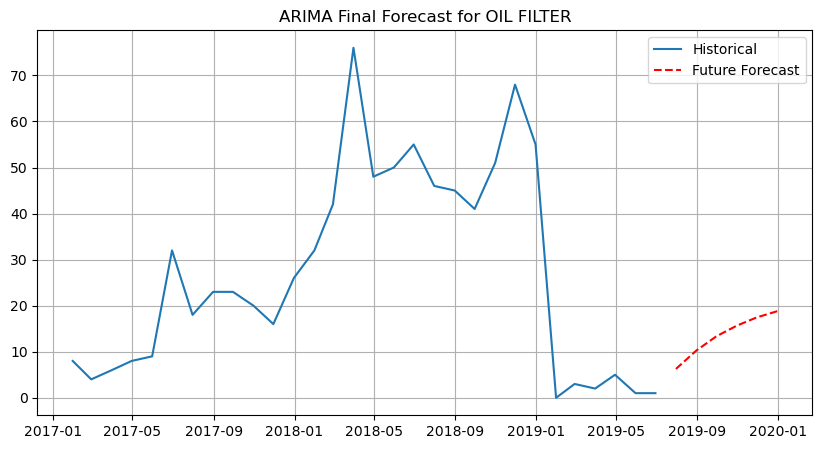

In [296]:
# Fitting ARIMA on full data

final_model = ARIMA(part_df, order=(1,0,0))
final_fit = final_model.fit()

# Forecast next 12 periods
future_forecast = final_fit.forecast(6)

# Plot final forecast
plt.figure(figsize=(10,5))
plt.plot(part_df, label='Historical')
plt.plot(future_forecast.index, future_forecast, label='Future Forecast', linestyle='--', color='red')
plt.title(f"ARIMA Final Forecast for {selected_part}")
plt.legend()
plt.grid(True)
plt.show()

In [298]:
future_forecast.head()

2019-07-31     6.264948
2019-08-31    10.278153
2019-09-30    13.337219
2019-10-31    15.668992
2019-11-30    17.446385
Freq: ME, Name: predicted_mean, dtype: float64

In [300]:
mae = mean_absolute_error(test, future_forecast)
rmse = np.sqrt(mean_squared_error(test, future_forecast))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 11.632816761689108
RMSE: 12.395882629289925


In [302]:
# Calculate average demand & variability from forecast
avg_demand = future_forecast.mean()
std_demand = future_forecast.std()

lead_time = 2   # We can take 2 months lead time to procure parts
z = 1.65        # for 95% service level

reorder_point = (avg_demand * lead_time) + (z * std_demand)
print(f"Recommended Reorder Point for {selected_part}: {reorder_point:.0f} units")

Recommended Reorder Point for OIL FILTER: 35 units


In [304]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(part_df)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("The series is stationary")
else:
    print("The series is not stationary. Differencing needed.") 

ADF Statistic: -3.2985932130277495
p-value: 0.014941475138678257
The series is stationary


In [306]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# PARAMETERS
forecast_horizon = 6   # number of months to forecast ahead
lead_time = 2          # business lead time in months
z = 1.65               # safety factor for 95% service level

results = []

# Loop through each part (using invoice_line_text as the part identifier)
for part_name, part_df in df.groupby("invoice_line_text"):
    try:
        # Prepare time series (monthly)
        part_series = part_df.set_index("invoice_date")["demand"]
        part_series = part_series.asfreq("M")          # monthly frequency
        part_series = part_series.fillna(0)            # fill missing months

        if len(part_series) < (forecast_horizon + 6):  # skip parts with very short history
            continue

        # Train/Test split
        train = part_series.iloc[:-forecast_horizon]
        test = part_series.iloc[-forecast_horizon:]

        # Fit ARIMA(1,0,0) as baseline
        model = ARIMA(train, order=(1,0,0))
        fit = model.fit()
        # Forecast on test
        forecast = fit.forecast(len(test))

        # Accuracy metrics
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))

        # Final Model on Full Data
        final_model = ARIMA(part_series, order=(1,0,0))
        final_fit = final_model.fit()
        future_forecast = final_fit.forecast(forecast_horizon)

        # Business Calculation: Reorder Point
        avg_demand = future_forecast.mean()
        std_demand = future_forecast.std()
        reorder_point = (avg_demand * lead_time) + (z * std_demand)

        # Save Results
        results.append({
            "part_name": part_name,
            "MAE": round(mae, 2),
            "RMSE": round(rmse, 2),
            "Next_Forecast": list(np.round(future_forecast.values, 2)),
            "Reorder_Point": round(reorder_point, 2)
        })
    except Exception as e:
        print(f"Skipping {part_name} due to error: {e}")
        continue

# Convert results to DataFrame
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display Results
print(results_df.head())

Skipping  due to error: 'demand'
Skipping 10 SIZE NUT due to error: 'demand'
Skipping 12 SIZE BOLT due to error: 'demand'
Skipping 3M OIL due to error: 'demand'
Skipping 4 WAY SWITCH due to error: 'demand'
Skipping 6004 BEARING due to error: 'demand'
Skipping 6202 BEARING due to error: 'demand'
Skipping 6303 BEARING due to error: 'demand'
Skipping 8 SIZE BOLT due to error: 'demand'
Skipping ACCELATOR CABLE due to error: 'demand'
Skipping ADD ON FEES due to error: 'demand'
Skipping AIR FILTER due to error: 'demand'
Skipping AIR FILTER CHECKUP due to error: 'demand'
Skipping AIR INTAKE due to error: 'demand'
Skipping AXLE due to error: 'demand'
Skipping BALANCING GEAR due to error: 'demand'
Skipping BATTERY due to error: 'demand'
Skipping BATTERY BELT due to error: 'demand'
Skipping BATTERY CHARGE due to error: 'demand'
Skipping BATTERY CLIP due to error: 'demand'
Skipping BATTERY TARMINAL due to error: 'demand'
Skipping BC UNIT due to error: 'demand'
Skipping BEARING due to error: 'dema

In [307]:
# Plot for each part
for part_name, part_df in df.groupby("invoice_line_text"):
    try:
        # Prepare time series
        part_series = part_df.set_index("invoice_date")["demand"].asfreq("M").fillna(0)

        if len(part_series) < (forecast_horizon + 6):
            continue

        # Fit ARIMA on full data
        model = ARIMA(part_series, order=(1,0,0))
        fit = model.fit()
        future_forecast = fit.forecast(forecast_horizon)

        # Plot
        plt.figure(figsize=(10, 4))
        plt.plot(part_series, label="Historical Demand", color="blue")
        plt.plot(future_forecast, label="Forecast", color="red", linestyle="--", marker="o")
        plt.title(f"Demand Forecast for {part_name}")
        plt.xlabel("Date")
        plt.ylabel("Demand")
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Skipping plot for {part_name} due to error: {e}")
        continue

Skipping plot for  due to error: 'demand'
Skipping plot for 10 SIZE NUT due to error: 'demand'
Skipping plot for 12 SIZE BOLT due to error: 'demand'
Skipping plot for 3M OIL due to error: 'demand'
Skipping plot for 4 WAY SWITCH due to error: 'demand'
Skipping plot for 6004 BEARING due to error: 'demand'
Skipping plot for 6202 BEARING due to error: 'demand'
Skipping plot for 6303 BEARING due to error: 'demand'
Skipping plot for 8 SIZE BOLT due to error: 'demand'
Skipping plot for ACCELATOR CABLE due to error: 'demand'
Skipping plot for ADD ON FEES due to error: 'demand'
Skipping plot for AIR FILTER due to error: 'demand'
Skipping plot for AIR FILTER CHECKUP due to error: 'demand'
Skipping plot for AIR INTAKE due to error: 'demand'
Skipping plot for AXLE due to error: 'demand'
Skipping plot for BALANCING GEAR due to error: 'demand'
Skipping plot for BATTERY due to error: 'demand'
Skipping plot for BATTERY BELT due to error: 'demand'
Skipping plot for BATTERY CHARGE due to error: 'demand'

In [309]:
# For simplicity, let's focus on a few common parts.
# We'll count occurrences of these keywords in the 'invoice_line_text'.
parts_to_track = ['OIL FILTER', 'AIR FILTER', 'BRAKE PAD', 'SPARK PLUG', 'ENGINE OIL']

# Create a new DataFrame to store the counts
time_series_data = []

for part in parts_to_track:
    # Count rows where the invoice text contains the part name
    part_demand = data1[data1['invoice_line_text'].str.contains(part, case=False, na=False)].copy()
    part_demand['spare_part'] = part
    time_series_data.append(part_demand)

# Combine into a single DataFrame
demand_df = pd.concat(time_series_data)

# Create the final time-series by counting parts per day
daily_demand = demand_df.groupby(['invoice_date', 'spare_part']).size().reset_index(name='quantity')
daily_demand.set_index('invoice_date', inplace=True)

print("Daily demand data :")
print(daily_demand.head())

Daily demand data :
              spare_part  quantity
invoice_date                      
2017-01-06    AIR FILTER         3
2017-01-06    ENGINE OIL         7
2017-01-07    AIR FILTER         7
2017-01-07    ENGINE OIL        12
2017-01-07    OIL FILTER         4


In [312]:
part

'ENGINE OIL'


Monthly demand for OIL FILTER:
invoice_date
2017-01-31    8
2017-02-28    4
2017-03-31    6
2017-04-30    8
2017-05-31    9
Freq: ME, Name: quantity, dtype: int64


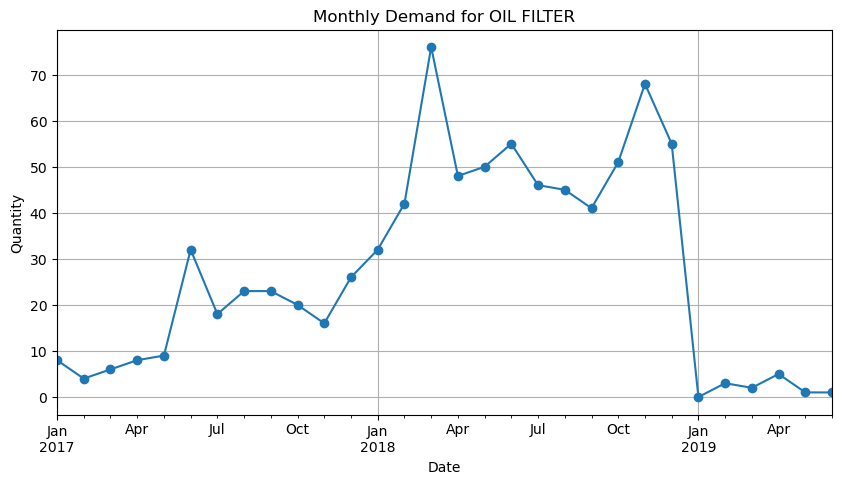

In [314]:
# --- This is where you select the part to analyze ---
selected_part = 'OIL FILTER'

# Isolate the data for the selected part
part_daily_demand = daily_demand[daily_demand['spare_part'] == selected_part]

# Resample to get total monthly demand. 'M' stands for Month-end frequency.
# '.sum()' adds up all quantities within that month.
part_df = part_daily_demand['quantity'].resample('M').sum()

print(f"\nMonthly demand for {selected_part}:")
print(part_df.head())


# --- Now, your plotting code will work perfectly ---
part_df.plot(figsize=(10, 5), marker='o')
plt.title(f"Monthly Demand for {selected_part}")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.grid(True)
plt.show()

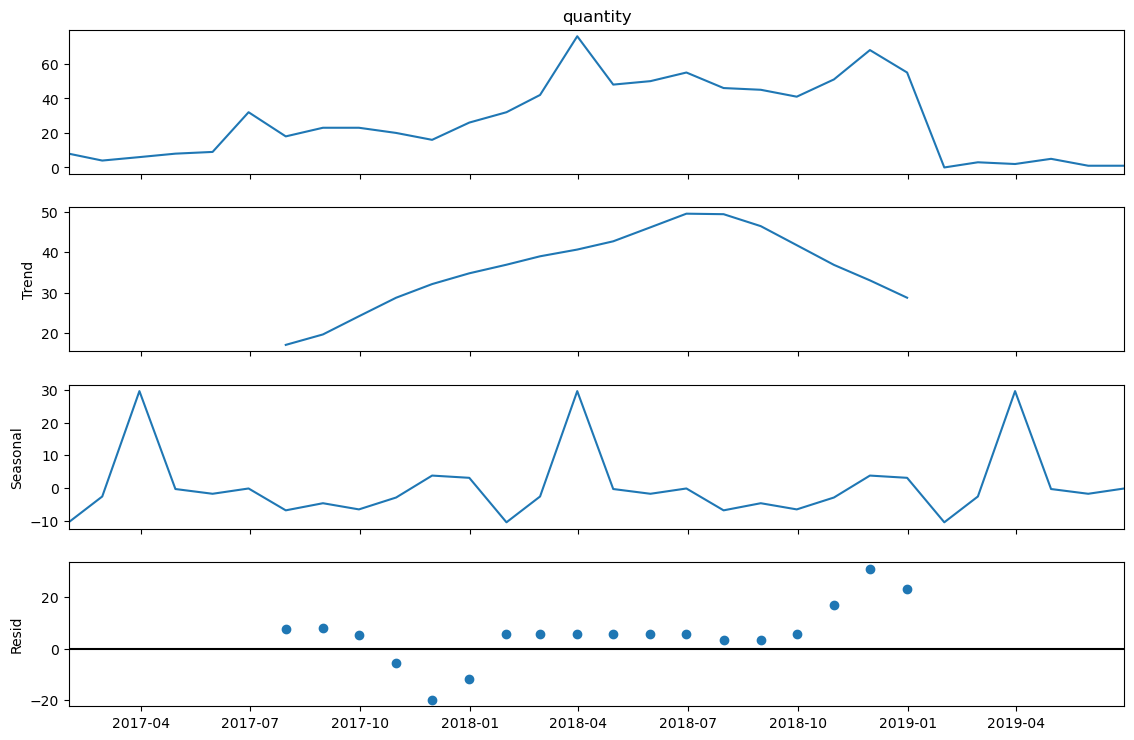

In [316]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series [To divide them as 'Trend', 'Seasonality', 'Residual']
decomposition = seasonal_decompose(part_df, model='additive')

# Plotting of decomposed components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [317]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(part_df.dropna()) # dropna() handles any missing months
p_value = result[1]

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {p_value}')

# A common threshold for the p-value is 0.05
if p_value <= 0.05:
    print("Result: The time series is stationary.")
else:
    print("Result: The time series is not stationary. You may need to apply differencing.")

ADF Statistic: -3.2985932130277495
p-value: 0.014941475138678257
Result: The time series is stationary.


## PLOTTING AUTOCORRELATION

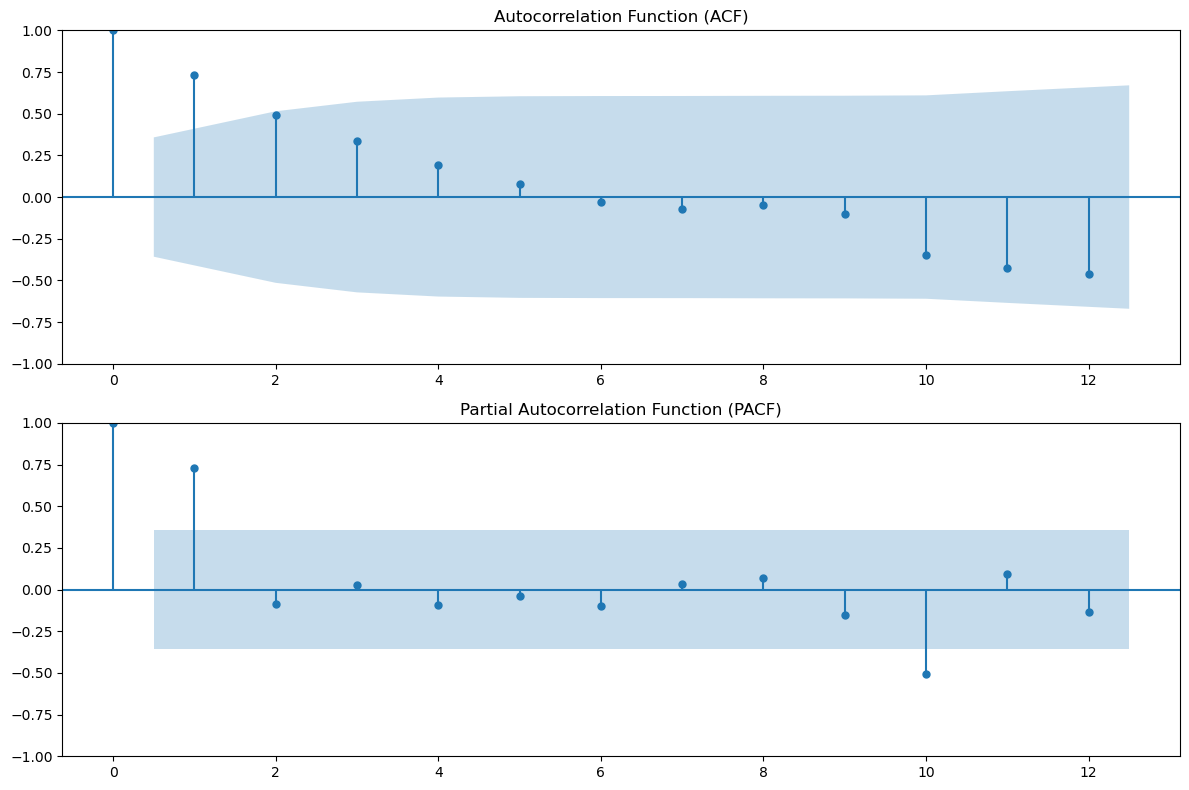

In [321]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Assuming 'part_df' is your monthly demand series for the selected part

# Generate ACF plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(part_df.dropna(), ax=ax1, lags=12) # Check up to 12 lags (1 year)
ax1.set_title('Autocorrelation Function (ACF)')

# Generate PACF plot
plot_pacf(part_df.dropna(), ax=ax2, lags=12)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [323]:
part_df

invoice_date
2017-01-31     8
2017-02-28     4
2017-03-31     6
2017-04-30     8
2017-05-31     9
2017-06-30    32
2017-07-31    18
2017-08-31    23
2017-09-30    23
2017-10-31    20
2017-11-30    16
2017-12-31    26
2018-01-31    32
2018-02-28    42
2018-03-31    76
2018-04-30    48
2018-05-31    50
2018-06-30    55
2018-07-31    46
2018-08-31    45
2018-09-30    41
2018-10-31    51
2018-11-30    68
2018-12-31    55
2019-01-31     0
2019-02-28     3
2019-03-31     2
2019-04-30     5
2019-05-31     1
2019-06-30     1
Freq: ME, Name: quantity, dtype: int64

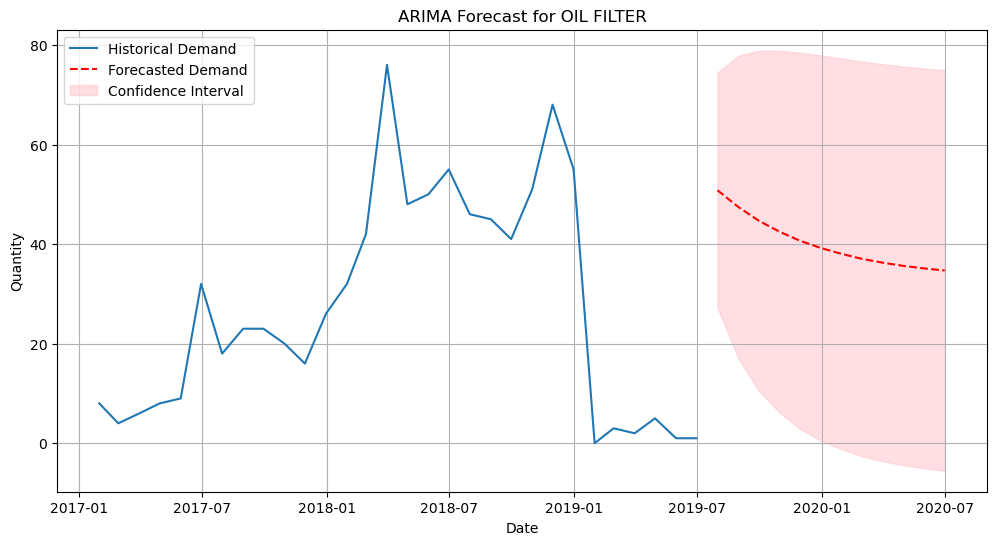


Forecasted Demand for the next 12 months:
2019-01-31    50.820645
2019-02-28    47.432025
2019-03-31    44.684532
2019-04-30    42.456866
2019-05-31    40.650675
2019-06-30    39.186215
2019-07-31    37.998832
2019-08-31    37.036102
2019-09-30    36.255521
2019-10-31    35.622625
2019-11-30    35.109474
2019-12-31    34.693411
Freq: ME, Name: predicted_mean, dtype: float64


In [329]:
#Forecast

# Forecast the next 12 months
forecast_steps = 12
forecast = fit.get_forecast(steps=forecast_steps)

# Get the predicted values and the confidence intervals
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a date range for the forecast period
last_date = part_df.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]

# --- Plot the results ---
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(part_df.index, part_df, label='Historical Demand')

# Plot the forecast
plt.plot(forecast_index, forecast_mean, label='Forecasted Demand', color='red', linestyle='--')

# Plot the confidence interval
plt.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='pink', alpha=0.5, label='Confidence Interval')

plt.title(f'ARIMA Forecast for {selected_part}')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()
print("\nForecasted Demand for the next 12 months:")
print(forecast_mean)

In [331]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Assume your preprocessed DataFrame is named 'df'
# and the 'invoice_date' column is already converted to datetime.
# df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# 1. Identify the top 10 most sold spare parts
top_10_parts = df['invoice_line_text'].value_counts().nlargest(10).index

# 2. Create a dictionary to store the forecast for each part and an index variable
all_forecasts = {}
forecast_index = None # Will store the index from the forecast

# 3. Loop through each of the top 10 parts
for part in top_10_parts:
    # Filter data for the current part and create a monthly time series
    part_df = df[df['invoice_line_text'] == part].set_index('invoice_date').resample('M').size()

    # Fit the ARIMA model
    model = ARIMA(part_df, order=(5, 1, 0))
    fit = model.fit()

    # Forecast the next 12 months
    forecast = fit.get_forecast(steps=12)
    forecast_mean = forecast.predicted_mean

    # On the first loop, save the forecast's index
    if forecast_index is None:
        forecast_index = forecast_mean.index

    # Store the forecast values (using .values to prevent index issues)
    all_forecasts[part] = forecast_mean.round().astype(int).values

# 4. Convert the dictionary of forecasts into a single DataFrame using the saved index
forecast_df = pd.DataFrame(all_forecasts, index=forecast_index)

# Format the index to show Year-Month
forecast_df.index = forecast_df.index.strftime('%Y-%m')

# 5. Display the final table
print("Forecasted Demand for Top 10 Spare Parts (Next 12 Months):")
print(forecast_df)

Forecasted Demand for Top 10 Spare Parts (Next 12 Months):
         ENGINE OIL  CHAIN LUBRICATION  GENERAL SERVICE  AIR FILTER  3M OIL  \
2019-07           4                  5                3           1       2   
2019-08           4                  4                3           2       1   
2019-09           5                  5                3           3       1   
2019-10           5                  5                3           2       2   
2019-11           5                  5                3           2       2   
2019-12           5                  5                3           2       2   
2020-01           5                  5                3           2       2   
2020-02           5                  5                3           2       1   
2020-03           5                  5                3           2       2   
2020-04           5                  5                3           2       2   
2020-05           5                  5                3           2     

In [333]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Assume your preprocessed DataFrame is named 'df'
# and the 'invoice_date' column is already converted to datetime.
# df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# 1. Identify the top 10 most sold spare parts
top_10_parts = df['invoice_line_text'].value_counts().nlargest(10).index

# 2. Create a dictionary to store the forecast for each part and an index variable
all_forecasts = {}
forecast_index = None # Will store the index from the forecast

# 3. Loop through each of the top 10 parts
for part in top_10_parts:
    # Filter data for the current part and create a monthly time series
    part_df = df[df['invoice_line_text'] == part].set_index('invoice_date').resample('M').size()

    # Fit the ARIMA model
    model = ARIMA(part_df, order=(5, 1, 0))
    fit = model.fit()

    # Forecast the next 12 months
    forecast = fit.get_forecast(steps=12)
    forecast_mean = forecast.predicted_mean

    # On the first loop, save the forecast's index
    if forecast_index is None:
        forecast_index = forecast_mean.index

    # Store the forecast values
    all_forecasts[part] = forecast_mean.round().astype(int).values

# 4. Convert the dictionary of forecasts into a single DataFrame
forecast_df = pd.DataFrame(all_forecasts, index=forecast_index)

# --- NEW: Calculate the total for each spare part ---
total_forecast = forecast_df.sum().reset_index()
total_forecast.columns = ['Spare Part', 'Total Forecasted Demand (12 Months)']

# 5. Display the final total demand table
print("Total Forecasted Demand for each Spare Part (Next 12 Months):")
print(total_forecast)

Total Forecasted Demand for each Spare Part (Next 12 Months):
          Spare Part  Total Forecasted Demand (12 Months)
0         ENGINE OIL                                   58
1  CHAIN LUBRICATION                                   59
2    GENERAL SERVICE                                   36
3         AIR FILTER                                   24
4             3M OIL                                   21
5        CONSUMABLES                                   23
6             POLISH                                   23
7           DISC OIL                                   30
8         BRAKE SHOE                                  -54
9         OIL FILTER                                   24


In [286]:
# Ensure Invoice Date is datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# Aggregate daily demand per part
daily_counts = (
    df.groupby([pd.Grouper(key='invoice_date', freq='D'), 'invoice_line_text'])
    .size()
    .reset_index(name='quantity')
)

# Rename columns for convenience
daily_counts = daily_counts.rename(columns={
    'invoice_date': 'date',
    'invoice_line_text': 'spare_part'
})

print(daily_counts.head())

        date           spare_part  quantity
0 2017-01-06               3M OIL         5
1 2017-01-06   AIR FILTER CHECKUP         3
2 2017-01-06           BRAKE SHOE         1
3 2017-01-06  CARBURETOR CLEANING         1
4 2017-01-06    CHAIN LUBRICATION         5


##  CONCLUSION

###  Forecasting Model Used
- **ARIMA** was applied to forecast monthly demand for each spare part using historical data (2017–2019).  
- Forecasts were generated for the next **12 months** to support inventory planning according to the JIT Standards.   

###  Model Insights
- ARIMA works well when enough past data is available and can capture autoregressive patterns in demand.  
- Sparse or inconsistent demand data reduces forecast accuracy, highlighting the need for better and continuous data collection.    


##  CHALLENGES FACED

1. **Limited Historical Data**  
   - Only 3 years (2017–2019) of data was available, which restricted the forecast horizon and reduced model accuracy.  

2. **Sparse Data for Some Parts**  
   - Certain parts like *BRAKE PAD* had very few records, making it difficult to generate reliable forecasts.  

3. **Stationarity Issues**  
   - The time series data was not stationary initially, requiring differencing and transformations before applying ARIMA.  

4. **Model Selection Complexity**  
   - Choosing the right ARIMA parameters was challenging, and even automated selection (auto_arima) sometimes gave flat or unrealistic forecasts.  

5. **Visualization Challenges**  
   - Faced errors related to `DatetimeIndex` during plotting, which needed debugging to align historical and forecast data properly.  
